In [1]:
! git clone https://github.com/broccubali/DLG-Assignments

Cloning into 'DLG-Assignments'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 100 (delta 27), reused 33 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 10.23 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00


In [53]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import numpy as np
import math

## Loading the data

In [4]:
train_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/train_stock_data.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m-%d') # date is a string make it a datetime obj
train_data.sort_values(['Ticker', 'Date'], inplace=True) # sort the ticker by date

In [5]:
validation_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/validation_stock_data.csv')
validation_data['Date'] = pd.to_datetime(validation_data['Date'], format='%Y-%m-%d')
validation_data.sort_values(['Ticker', 'Date'], inplace=True)

In [6]:
with open('/content/DLG-Assignments/ASSignment2/hyperedges.json', 'r') as f:
    hyperedges = json.load(f) # load the hyperedge defintions

In [7]:
with open('/content/DLG-Assignments/ASSignment2/blind_test_cases.json', 'r') as f:
    test_cases = json.load(f)

In [8]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Number of hyperedges: {len(hyperedges)}")
print(f"Number of test cases: {len(test_cases)}")
print("Available tickers in training data:", train_data['Ticker'].unique())

Training data shape: (20160, 102)
Validation data shape: (2000, 102)
Number of hyperedges: 8
Number of test cases: 120
Available tickers in training data: ['AAPL' 'AMZN' 'BA' 'BAC' 'C' 'CAT' 'CVX' 'DUK' 'GOOGL' 'JNJ' 'JPM' 'KO'
 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'VZ' 'WMT' 'XOM']


## Preprocessing

In [9]:
l = []  # Initialize an empty list to store preprocessed rows

tickers = train_data['Ticker'].unique()  # Get a list of unique tickers

for ticker in tickers:
    data = train_data[train_data["Ticker"] == ticker]  # Filter data for the current ticker

    valid_cols = []  # List to store columns without missing values

    for i in data.columns:
        if data[i].isna().sum() == 0:  # Check if the column has no NaN values
            valid_cols.append(i)  # Add it to the valid columns list

    a = data[valid_cols].values  # Extract only the valid columns as a numpy array

    for i in a:
        l.append(i)  # Add each row to the final preprocessed list

# Convert the list of clean rows into a DataFrame with proper column names
df = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])


In [10]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change() # percentage change in closing price (i am finance bro now)
df['Volatility'] = df.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True) # 30 day window for rolling volatility
df['Momentum'] = df.groupby('Ticker')['Close'].pct_change(periods=5) # 5 day momentum (price change)
df['Moving_Avg'] = df.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)
df.fillna(0, inplace=True) # if nan make 0

In [12]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Volatility', 'Momentum', 'Moving_Avg']

In [13]:
# scaler = StandardScaler()
# scaler = MinMaxScaler() # loss was 52354522137231.3594 gg
scaler = RobustScaler() # Val Loss: 0.1693
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [14]:
# ticker to index mapping
sorted_tickers = sorted(tickers) # first sort alphabetically
ticker_to_idx = {ticker: idx for idx, ticker in enumerate(sorted_tickers)} # dict mapping
print("Ticker to index mapping:", ticker_to_idx)

Ticker to index mapping: {'AAPL': 0, 'AMZN': 1, 'BA': 2, 'BAC': 3, 'C': 4, 'CAT': 5, 'CVX': 6, 'DUK': 7, 'GOOGL': 8, 'JNJ': 9, 'JPM': 10, 'KO': 11, 'MRK': 12, 'MSFT': 13, 'PFE': 14, 'PG': 15, 'T': 16, 'VZ': 17, 'WMT': 18, 'XOM': 19}


## HGNN Model

In [15]:
# node to hyperedge maps (incidence matrix)
num_nodes = len(sorted_tickers) # number of stocks (nodes)
num_hyperedges = len(hyperedges) # number of hyperedges (industry)

In [16]:
# Create node-to-hyperedge incidence matrix
# For HypergraphConv we need:
# 1. hyperedge_index: list of [node_idx, hyperedge_idx] pairs
# 2. hyperedge_weight: weight for each hyperedge
# gpt helped here big time

hyperedge_index = [] # pairs of node_index, hyperedge_index
for he_idx, (he_name, he_tickers) in enumerate(hyperedges.items()):
    for ticker in he_tickers:
        node_idx = ticker_to_idx[ticker] # get node index frmo tivker
        hyperedge_index.append([node_idx, he_idx]) # add connection between node and hyperedge

In [17]:
hyperedge_index = torch.tensor(hyperedge_index, dtype=torch.long).t() # transpose for 2*N tensor
hyperedge_weight = torch.ones(num_hyperedges, dtype=torch.float) # all hyperedges get weight 1

In [18]:
# double check
print(f"Hyperedge index shape: {hyperedge_index.shape}")
print(f"Hyperedge weight shape: {hyperedge_weight.shape}")

Hyperedge index shape: torch.Size([2, 20])
Hyperedge weight shape: torch.Size([8])


In [19]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker') # filter data fr given date
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values # target (output)
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [21]:
# make each date a snapshot of the graph
dates = sorted(df['Date'].unique())
graph_snapshots = []
for date in dates:
    x_t, y_t = get_features_for_date(df, date, sorted_tickers, features)
    graph_snapshots.append((x_t, y_t))

In [22]:
# graph objects for pytorch geo
train_graphs = []
for x_t, y_t in graph_snapshots:
    # DATA OBJECT with node features, hyperedge
    graph = Data(x=x_t, hyperedge_index=hyperedge_index, hyperedge_attr=hyperedge_weight, y=y_t)
    train_graphs.append(graph)

In [23]:
l_val = []
val_tickers = sorted(validation_data['Ticker'].unique())
for ticker in val_tickers:
    data = validation_data[validation_data["Ticker"] == ticker] # basically since 8 in the val and 20 in the train, you match the ticker in val to the one in train
    # nice
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l_val.append(i)
df_val = pd.DataFrame(l_val, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])

In [24]:
df_val['Return'] = df_val.groupby('Ticker')['Close'].pct_change()
df_val['Volatility'] = df_val.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True)
df_val['Momentum'] = df_val.groupby('Ticker')['Close'].pct_change(periods=5)
df_val['Moving_Avg'] = df_val.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)
df_val.fillna(0, inplace=True)

In [25]:
# normalize
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

In [26]:
val_dates = sorted(df_val['Date'].unique())
val_graph_snapshots = []
for date in val_dates:
    x_t, y_t = get_features_for_date(df_val, date, sorted_tickers, features)
    val_graph_snapshots.append((x_t, y_t))

In [27]:
val_graphs = []
for x_t, y_t in val_graph_snapshots:
    graph = Data(x=x_t, hyperedge_index=hyperedge_index, hyperedge_attr=hyperedge_weight, y=y_t)
    val_graphs.append(graph)

In [28]:
class StockHGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5):
        super().__init__() # parent class
        # first hypergraph convolution layer: input_features -> hidden_features
        self.hgconv1 = HypergraphConv(in_channels, hidden_channels)

        # second hypergraph convolution layer: hidden_features -> output_features
        self.hgconv2 = HypergraphConv(hidden_channels, out_channels)

    def forward(self, x, hyperedge_index, hyperedge_weight=None):
        # apply first layer with ELU activation function
        x = F.elu(self.hgconv1(x, hyperedge_index, hyperedge_weight))

        # next is applying second layer (no activation for regression output)
        x = self.hgconv2(x, hyperedge_index, hyperedge_weight)
        return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockHGNN(in_channels=len(features), hidden_channels=32, out_channels=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss() # cuz regressuion
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False)

In [31]:
hyperedge_index = hyperedge_index.to(device)
hyperedge_weight = hyperedge_weight.to(device)

In [39]:
epochs = 50
train_losses, val_losses = [], []

In [40]:
for epoch in range(epochs):
    # Training
    model.train() # set to training mode
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device) # bacth data to devoce
        optimizer.zero_grad() # clear prev gradients
        out = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr) # forward pass
        loss = loss_fn(out, batch.y) # get the loss
        loss.backward() # back prop
        optimizer.step() # update weights
        train_loss += loss.item() # accumulate loss
    train_loss /= len(train_loader) # avg loss
    train_losses.append(train_loss) # store for when we plot

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 | Train Loss: 0.3292 | Val Loss: 0.1757


Epoch 2 | Train Loss: 0.3291 | Val Loss: 0.1744


Epoch 3 | Train Loss: 0.3291 | Val Loss: 0.1734


Epoch 4 | Train Loss: 0.3290 | Val Loss: 0.1725


Epoch 5 | Train Loss: 0.3290 | Val Loss: 0.1723


Epoch 6 | Train Loss: 0.3290 | Val Loss: 0.1709


Epoch 7 | Train Loss: 0.3290 | Val Loss: 0.1708


Epoch 8 | Train Loss: 0.3289 | Val Loss: 0.1705


Epoch 9 | Train Loss: 0.3289 | Val Loss: 0.1702


Epoch 10 | Train Loss: 0.3289 | Val Loss: 0.1702


Epoch 11 | Train Loss: 0.3289 | Val Loss: 0.1700


Epoch 12 | Train Loss: 0.3289 | Val Loss: 0.1696


Epoch 13 | Train Loss: 0.3289 | Val Loss: 0.1694


Epoch 14 | Train Loss: 0.3289 | Val Loss: 0.1692


Epoch 15 | Train Loss: 0.3289 | Val Loss: 0.1692


Epoch 16 | Train Loss: 0.3289 | Val Loss: 0.1692


Epoch 17 | Train Loss: 0.3289 | Val Loss: 0.1691


Epoch 18 | Train Loss: 0.3288 | Val Loss: 0.1690


Epoch 19 | Train Loss: 0.3289 | Val Loss: 0.1692


Epoch 20 | Train Loss: 0.3289 | Val Loss: 0.1689


Epoch 21 | Train Loss: 0.3288 | Val Loss: 0.1690


Epoch 22 | Train Loss: 0.3289 | Val Loss: 0.1689


Epoch 23 | Train Loss: 0.3288 | Val Loss: 0.1689


Epoch 24 | Train Loss: 0.3289 | Val Loss: 0.1689


Epoch 25 | Train Loss: 0.3288 | Val Loss: 0.1689


Epoch 26 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 27 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 28 | Train Loss: 0.3288 | Val Loss: 0.1689


Epoch 29 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 30 | Train Loss: 0.3289 | Val Loss: 0.1688


Epoch 31 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 32 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 33 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 34 | Train Loss: 0.3288 | Val Loss: 0.1687


Epoch 35 | Train Loss: 0.3288 | Val Loss: 0.1689


Epoch 36 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 37 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 38 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 39 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 40 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 41 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 42 | Train Loss: 0.3288 | Val Loss: 0.1687


Epoch 43 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 44 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 45 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 46 | Train Loss: 0.3288 | Val Loss: 0.1687


Epoch 47 | Train Loss: 0.3288 | Val Loss: 0.1687


Epoch 48 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 49 | Train Loss: 0.3288 | Val Loss: 0.1688


Epoch 50 | Train Loss: 0.3288 | Val Loss: 0.1688


In [41]:
model.eval() # now set model to evaluation mode
preds_list, actuals_list = [], []
with torch.no_grad(): # no gradient evaluation
    for batch in tqdm(val_loader, desc="Making Predictions", leave=False):
        batch = batch.to(device)
        preds = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr)
        preds_list.append(preds.cpu()) # store preds
        actuals_list.append(batch.y.cpu()) # store actual values

In [42]:
preds = torch.cat(preds_list, dim=0)
actuals = torch.cat(actuals_list, dim=0)

In [43]:
# kick out zero values
mask = actuals.abs().sum(dim=1) > 0  # mask for non-zero rows
preds = preds[mask].numpy()  # Apply mask  like we all do in life
actuals = actuals[mask].numpy()

In [44]:
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / np.clip(np.abs(actuals), 1e-10, None))) * 100

In [46]:
pred_df = pd.DataFrame(preds, columns=["Open", "High", "Low", "Close", "Volume"])
actual_df = pd.DataFrame(actuals, columns=["Open", "High", "Low", "Close", "Volume"])

In [47]:
# scale back up now
#copies for the inverse-transformed data
pred_df_og = pred_df.copy()
actual_df_og = actual_df.copy()

In [48]:
pred_df_og[feature_cols] = scaler.inverse_transform(pred_df[feature_cols])
actual_df_og[feature_cols] = scaler.inverse_transform(actual_df[feature_cols])

In [50]:
og_rmse = np.sqrt(mean_squared_error(actual_df_og, pred_df_og))
og_mape = np.mean(np.abs((actual_df_og - pred_df_og) / np.clip(np.abs(actual_df_og), 1e-10, None))) * 100
print(f"Original Scale RMSE: {og_rmse:.4f}")
print(f"Original Scale MAPE: {og_mape:.2f}%")

Original Scale RMSE: 6033094.6001
Original Scale MAPE: 34.62%


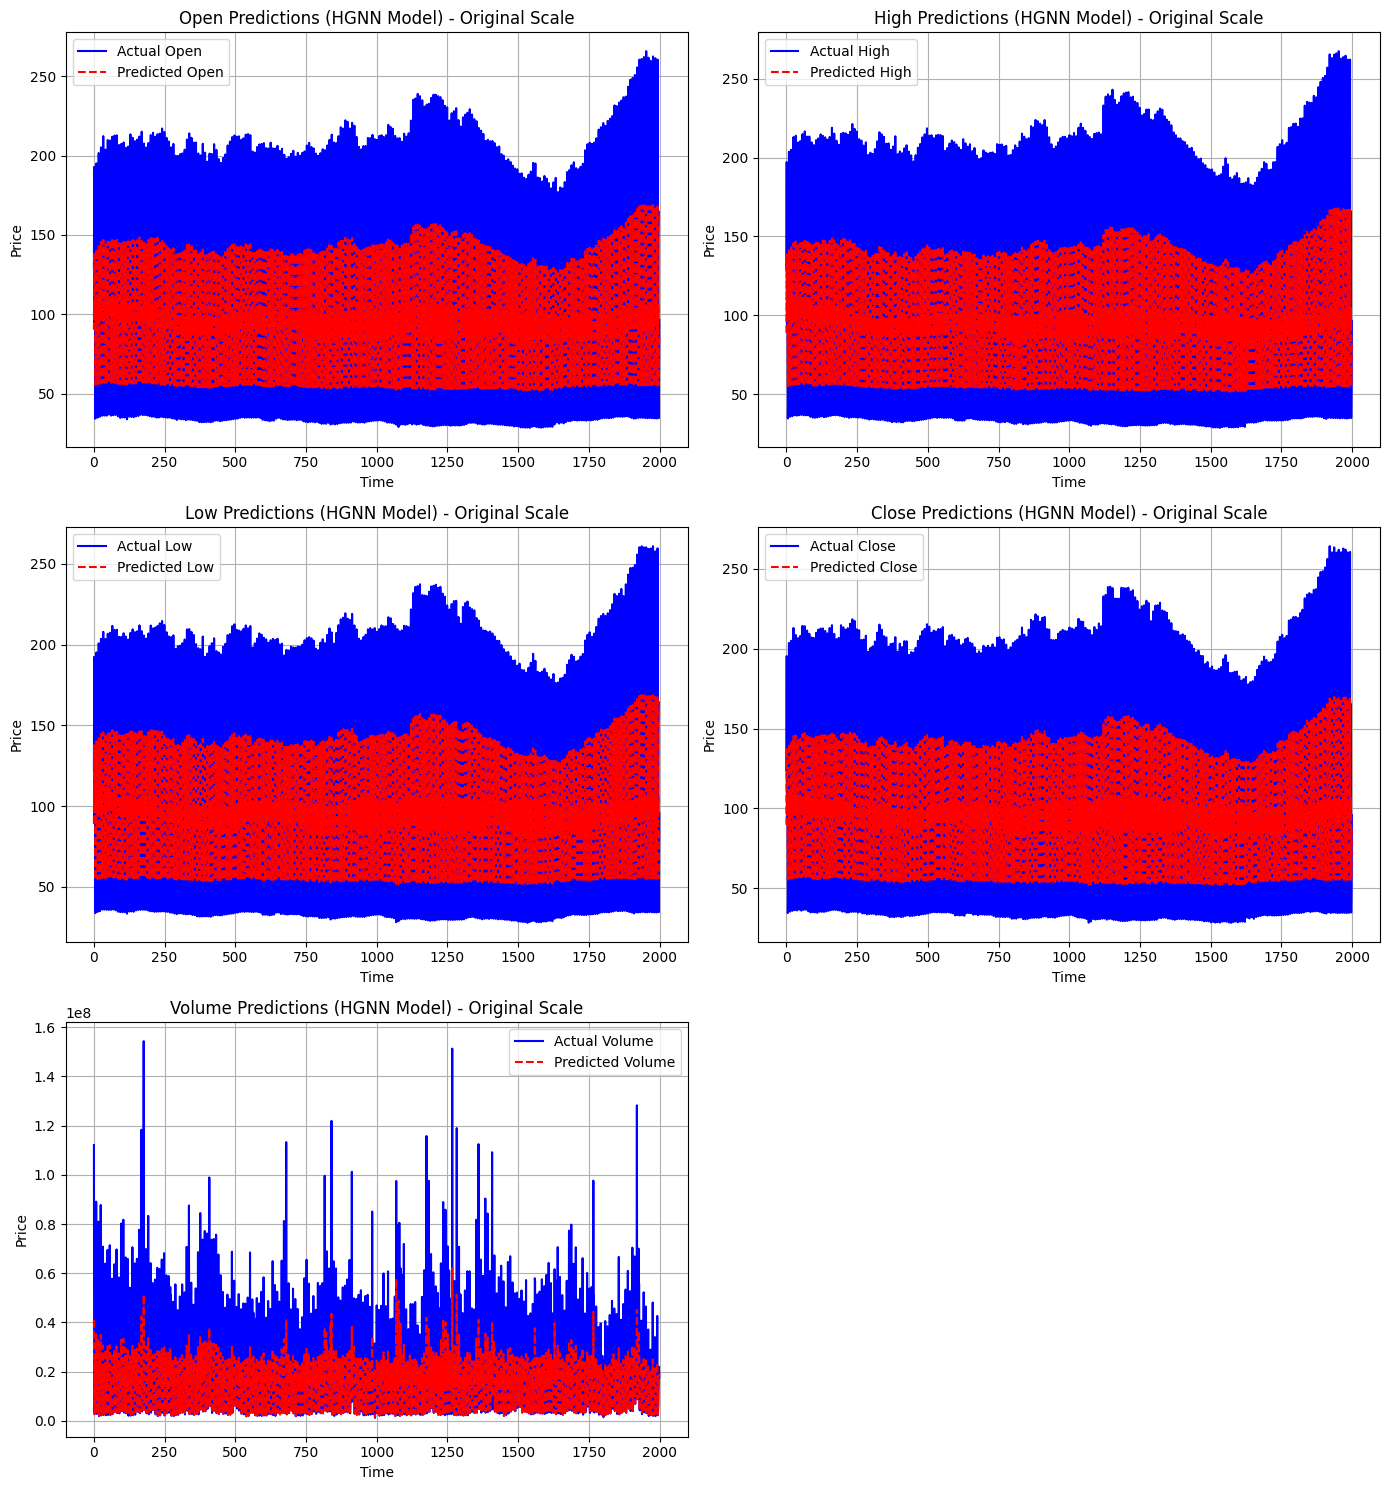

In [55]:
num_cols = len(pred_df_og.columns)
cols = 2
rows = math.ceil(num_cols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

for idx, column in enumerate(pred_df_og.columns):
    ax = axes[idx]
    ax.plot(actual_df_og[column], label=f"Actual {column}", color="blue")
    ax.plot(pred_df_og[column], label=f"Predicted {column}", color="red", linestyle="dashed")
    ax.set_title(f"{column} Predictions (HGNN Model) - Original Scale")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.grid(True)
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## GAT

In [56]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
import networkx as nx

In [57]:
hyperedge_indices = []
for he_name, ticker in hyperedges.items():
    indices = [ticker_to_idx[t] for t in ticker]
    print(f"Hyperedge '{he_name}': {ticker} -> {indices}")
    hyperedge_indices.append(indices)

Hyperedge 'Tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'] -> [0, 8, 13, 1]
Hyperedge 'Finance': ['JPM', 'BAC', 'C'] -> [10, 3, 4]
Hyperedge 'Healthcare': ['JNJ', 'PFE', 'MRK'] -> [9, 14, 12]
Hyperedge 'Energy': ['XOM', 'CVX'] -> [19, 6]
Hyperedge 'Consumer': ['WMT', 'PG', 'KO'] -> [18, 15, 11]
Hyperedge 'Industrials': ['BA', 'CAT'] -> [2, 5]
Hyperedge 'Communications': ['VZ', 'T'] -> [17, 16]
Hyperedge 'Utilities': ['DUK'] -> [7]


In [58]:
hyperedge_indices

[[0, 8, 13, 1],
 [10, 3, 4],
 [9, 14, 12],
 [19, 6],
 [18, 15, 11],
 [2, 5],
 [17, 16],
 [7]]

In [59]:
# clique representation
adj_matrix = [[0 for i in range(20)] for j in range(20)]
for hyperedge in hyperedge_indices:
    for i in range(len(hyperedge)):
        for j in range(i+1, len(hyperedge)):
            adj_matrix[hyperedge[i]][hyperedge[j]] = 1
            adj_matrix[hyperedge[j]][hyperedge[i]] = 1
adj_matrix = np.array(adj_matrix)
adj_matrix

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  2,  3,  3,  4,  4,  5,  6,  8,  8,  8,  9,  9,
         10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 19],
        [ 1,  8, 13,  0,  8, 13,  5,  4, 10,  3, 10,  2, 19,  0,  1, 13, 12, 14,
          3,  4, 15, 18,  9, 14,  0,  1,  8,  9, 12, 11, 18, 17, 16, 11, 15,  6]])

In [61]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker')
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
dates = sorted(df['Date'].unique())
graph_snapshots = []
tickers = sorted(df['Ticker'].unique())
for date in dates:
    x_t, y_t = get_features_for_date(df, date, tickers, target_cols)
    graph_snapshots.append((x_t, y_t))

In [62]:
graphs = []

for x_t, y_t in graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    graphs.append(graph)

In [63]:
graphs[0]

Data(x=[20, 5], edge_index=[2, 36], y=[20, 5])

In [65]:
val_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/validation_stock_data.csv')
val_data['Date'] = pd.to_datetime(val_data['Date'], format='%Y-%m-%d')
val_data.sort_values(['Ticker', 'Date'], inplace=True)
l = []
val_tickers = sorted(val_data['Ticker'].unique())
for ticker in val_tickers:
    data = val_data[val_data["Ticker"] == ticker]
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df1 = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
df1

,Date,Ticker,Open,High,Low,Close,Volume
0,2023-01-03,AAPL,128.782649,129.395518,122.742873,123.632530,112117500.0
1,2023-01-04,AAPL,125.431607,127.181268,123.642412,124.907700,89113600.0
2,2023-01-05,AAPL,125.668857,126.301500,123.326101,123.583107,80962700.0
3,2023-01-06,AAPL,124.561702,128.792501,123.454572,128.130203,87754700.0
4,2023-01-09,AAPL,128.970458,131.876670,128.397123,128.654129,70790800.0
...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,98.058076,98.661898,97.588442,97.674706,12921800.0
1996,2023-12-26,XOM,98.470205,98.748153,97.875976,97.895142,16835100.0
1997,2023-12-27,XOM,97.799294,98.288101,97.128381,97.435089,14558800.0
1998,2023-12-28,XOM,97.176310,97.387168,95.968673,96.026184,16329300.0


In [69]:
df2 = df1[feature_cols].copy()
df1[feature_cols] = scaler.transform(df1[feature_cols])

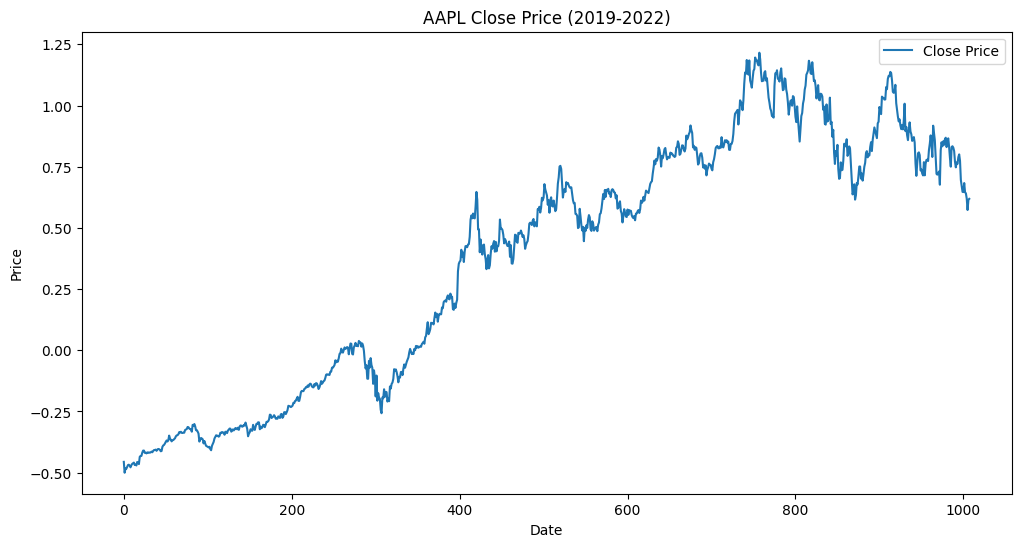

In [70]:
aapl = df[df["Ticker"] == "AAPL"]
plt.figure(figsize=(12, 6))
plt.plot(aapl.index, aapl['Close'], label='Close Price')
plt.title('AAPL Close Price (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
# scaled btw

In [73]:
dates = sorted(df1['Date'].unique())
val_graph_snapshots = []

for date in dates:
    x_t, y_t = get_features_for_date(df1, date, tickers, target_cols)
    val_graph_snapshots.append((x_t, y_t))

In [74]:
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F

class StockGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5, heads=32, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden_channels * heads)

        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(hidden_channels * heads)

        self.gat3 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.norm3 = nn.LayerNorm(hidden_channels)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.scale_factor = nn.Parameter(torch.ones(out_channels))
        self.scale_bias = nn.Parameter(torch.zeros(out_channels))


    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.norm1(x)

        x = F.elu(self.gat2(x, edge_index))
        x = self.norm2(x)

        x = F.elu(self.gat3(x, edge_index))
        x = self.norm3(x)

        out = self.regressor(x)
        return out * self.scale_factor + self.scale_bias

In [75]:
model = StockGAT(
    in_channels=len(target_cols),
    hidden_channels=128,
    out_channels=5,
    heads=32,
    dropout=0.3
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

In [76]:
train_loader = DataLoader(graphs, batch_size=64, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=64, shuffle=False)

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
edge_index = edge_index.to(device)
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1280x9 and 5x4096)